In [30]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)


mpl.style.use('ggplot')
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.rc('figure', figsize=(14, 10))#设置图片大小
sns.set_style('white')

%run Util.ipynb
%run Constant.ipynb
%run Policy_Loader.ipynb
%run BreakSectionManager.ipynb
%run Operation.ipynb
%run Evaluation.ipynb
%run AccountSavior.ipynb


# 沿着时间线，模拟买卖
class ProRocketRegression:
    
    def __init__(self,symbols,start_date,end_date,policy_name):
        self.symbols = symbols
        
        self.start_date = start_date
        self.end_date = end_date
        self.policy_name = policy_name
        
        self.policy_loader = Policy_Loader(self.policy_name)
        self.debug = self.policy_loader.enabled_log_debug()
        self.context = self.policy_loader.get_context()
        
        self.level = self.context['level']
        self.short = self.context['short']
        self.mid = self.context['mid']
        
        self.account_savior = AccountSavior(is_on_prod=False)
        
        self.operations={}
        
        
    def get_to_buy_candidate_stocks(self,cur_date,account,all_sections):
        already_bought = set(account.get_already_bought_symbols())
        
        part = all_sections[all_sections['d_s_date']==cur_date]
        
        if(part.shape[0]>0):
            stocks = part['symbol'].values
            
            for s in stocks:
                already_bought.add(s)
    
            if(self.debug==True):
                print(cur_date+' found to buy stocks '+ str(already_bought))
                
        return list(already_bought)
    
    
    def get_to_sell_candidate_stocks(self,cur_date,account):
        symbols = list(set(account.get_all_position_symbols()))
        
        return symbols
        
    def get_all_sections(self):
        all_sections = pd.DataFrame(columns=break_section_columns)
        for symbol in self.symbols:
            sectionManager = BreakSectionManager(symbol,self.context)
            section_df = sectionManager.get_all_break_sections()
            
            all_sections = pd.concat([section_df,all_sections], ignore_index=True, sort=False)
            
        return all_sections
    
    def try_to_buy(self,cur_date,candidates,account):
        if(candidates is None):
            return
        
        for symbol in candidates:
            operation = Operation(account,symbol,self.context,self.policy_name)
        
            if(operation.is_buy_point(cur_date)==True):
                operation.open_opsition(cur_date)


    def try_to_sell(self,cur_date,candidates,account):
        for symbol in candidates:
            operation = Operation(account,symbol,self.context,self.policy_name)
            
            if(operation.is_sell_point(cur_date)==True):
                if(self.debug==True):
                    print('try to sell '+ symbol)

                operation.sell_stock(cur_date)
            
    def build_asset_file_path(self):
        return multip_report+'multip_stocks_account_asset_'+str(self.short)+'_'+str(self.mid)+'_'+self.level+'_'+operation_version+'.csv'
    
    def build_deal_file_path(self):
        return multip_report+'multip_stocks_deals_'+str(self.short)+'_'+str(self.mid)+'_'+self.level+'_'+operation_version+'.csv'
    
    def persist(self,account):
        account.get_asset_df().to_csv(self.build_asset_file_path(),index=False)
        account.deal_df.to_csv(self.build_deal_file_path(),index=False)
        
    def draw_asset(self):
        if(self.policy_loader.enable_painter()==True):
            painter = AssetPainter()

            asset_file = self.build_asset_file_path()
            painter.draw_month_profit_bars(asset_file)
            painter.draw_audit_asset_bars(asset_file)

    def start_regression(self,draw_pic=False):
        start_datetime = to_datetime(self.start_date)
        end_datetime = to_datetime(self.end_date)
       
        all_sections = self.get_all_sections()
        market = Metric('SH#999999',self.context)

        account = Account(self.context,self.policy_name)
        while(start_datetime<=end_datetime):
            cur_date = start_datetime.strftime(YMD_format)
            
            if(self.policy_loader.enabled_account_snapshot()==True):
                yesterday_account = self.account_savior.restore_account(get_yesterday(cur_date))
                if(yesterday_account is not None):
                    account = yesterday_account
            
            if(market.is_today_open(cur_date)):
                account.daily_audit(cur_date)

                if(account.can_open_new_stock()==True):
                    candidates = self.get_to_buy_candidate_stocks(cur_date,account,all_sections)
                    self.try_to_buy(cur_date,candidates,account)
                    
                if(account.has_shares()==True):
                    candidates = self.get_to_sell_candidate_stocks(cur_date,account)
                    self.try_to_sell(cur_date,candidates,account)
                    
                    
            if(self.policy_loader.enabled_account_snapshot()==True):
                self.account_savior.persist_account(account,cur_date)
            start_datetime += dt.timedelta(days = 1)
            
            if((int(cur_date.split('-')[2])==28) and (int(cur_date.split('-')[1])==2)):
                print(cur_date,end=' ')
      
        self.persist(account)
        self.draw_asset()
        evaluation = Evaluation(account,self.context,self.policy_name)
        evaluation_df = evaluation.get_evaluation_report_of_multip_stocks(self.start_date,self.end_date)
        if(len(self.symbols)==1):
            evaluation_df['symbol'] = self.symbols[0]
        
        if(draw_pic==True):
            plt.rc('figure', figsize=(18,12))
            account.asset['assets'].plot(kind='bar')
            plt.show()

            account.asset['space_per'].plot(kind='bar')
            plt.show()

        print('regression done !')
            
        return evaluation_df



<IPython.core.display.Javascript object>

2007-02-28 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide



year_returns
[37.23]
Compound avg year rate
[]


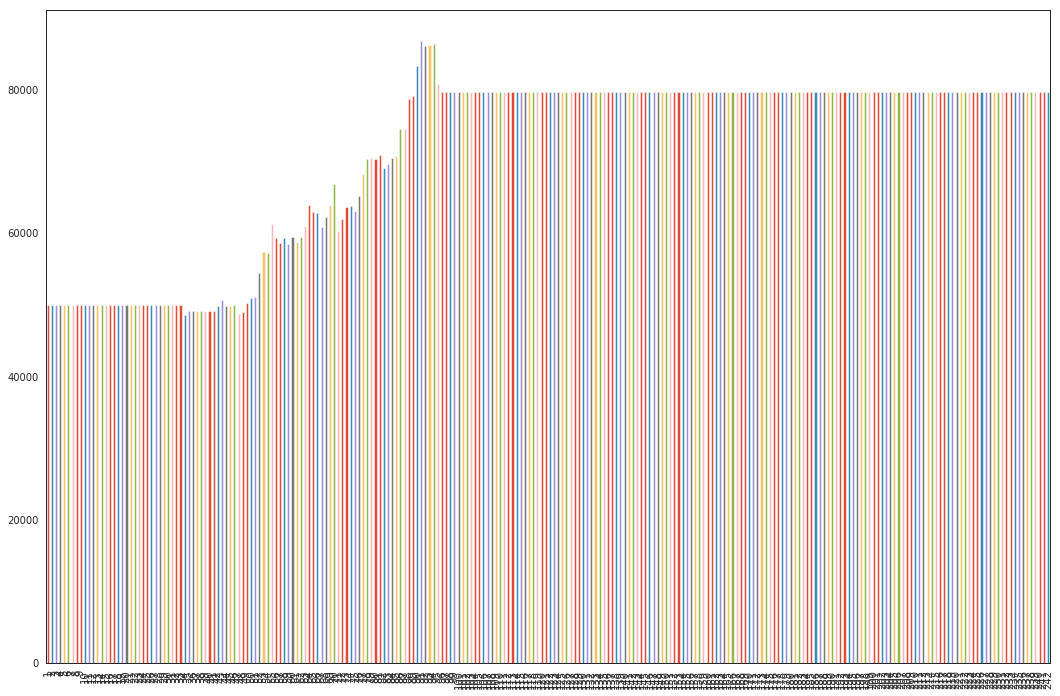

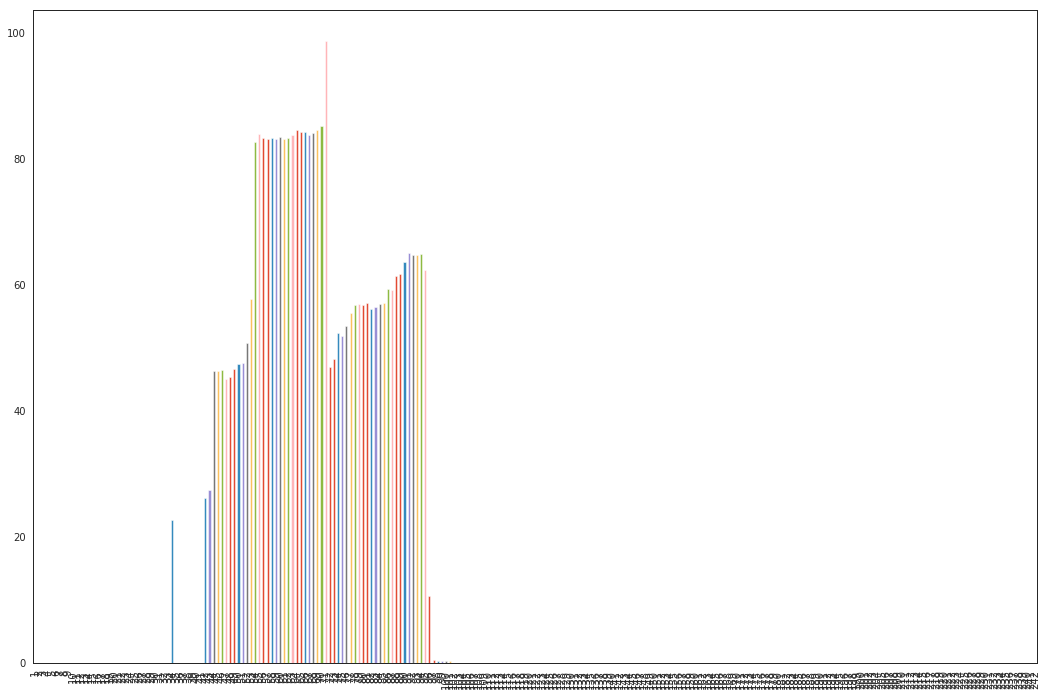

regression done !


,symbol,start_date,end_date,avg_drawdown,float_profit_drawdown,avg_year_return,year_regular_return,mean_year_return,mean_month_return,profit_month_rate
1,all_symbols,2007-01-01,2008-01-01,8.219893,9.75,inf,214.37,37.23,4.110833,83.33


In [31]:
start = '2007-01-01'
end = '2008-01-01'
policy_name='rocket_break_v8_start_real_world_v0.1.json'

symbols = get_symbol_slices(0,3,data_dir)
regression = ProRocketRegression(symbols,start,end,policy_name)
evaluation_df = regression.start_regression(True)

evaluation_df[display_evaluation_columns]

In [ ]:
metric = Evaluation_Metric(regression.account)
metric.year_return_rate_array()
plt.plot(range(0,len(metric.get_CAGR_array())),metric.get_CAGR_array())

In [ ]:
# 不同的选股对于算法稳定性的检查
def simulate(scale_start,scale_end):
    scale = 60
    start = '2000-02-01'
    end = '2019-08-30'
    policy_name='rocket_break_v7_upgrade_honor_account_v0.4.json'

    regression = ProRocketRegression(scale_start,scale_end,start,end,policy_name)
    evaluation_df = regression.start_regression()
    
    columns = ['policy_name','short','mid','in_hand_asset_drawdown','avg_drawdown','float_profit_drawdown','avg_year_return',
              'year_regular_return','mean_year_return','std_year_return','mean_month_return','std_month_return','profit_month_rate']
    display(evaluation_df[columns])
    plt.rc('figure', figsize=(18,12))
    regression.account.asset['assets'].plot(kind='bar')
    plt.show()
    
    plt.rc('figure', figsize=(18,12))
    regression.account.asset['space_per'].plot(kind='bar')
    plt.show()
    

# simulate(0,120)
# simulate(120,240)
# simulate(240,360)
# simulate(360,480)

